In [42]:
import torch
from captum.attr import IntegratedGradients
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [2]:
#config

print(torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
print(f"Using device: {device}")


2.5.0.dev20240619
Using device: cpu


In [3]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
test_dir = "../chest_xray/test"


In [5]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [6]:
batch_size = 1


In [7]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
class PneumoniaScannerModel(torch.nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoniaScannerModel, self).__init__()
        self.base_model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        for param in self.base_model.parameters():
            param.requires_grad = False

        num_out_ftrs = self.base_model.fc.out_features
        self.fc = torch.nn.Linear(num_out_ftrs, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = PneumoniaScannerModel().to(device)


In [9]:
model_pickle_path = "../Model/PneumoniaScannerModel_wSampler.pth"


In [10]:
model.load_state_dict(torch.load(model_pickle_path))


<All keys matched successfully>

In [31]:
dataiter = iter(test_loader)
batch = next(dataiter)
images, labels = batch


In [32]:
labels.item()


0

In [33]:
images.to(device)


tensor([[[[-1.6042, -1.5699, -1.5699,  ..., -1.5528, -1.5699, -1.6042],
          [-1.6042, -1.5699, -1.5699,  ..., -1.5870, -1.5699, -1.6042],
          [-1.6213, -1.5699, -1.5699,  ..., -1.5870, -1.5699, -1.6213],
          ...,
          [-1.6555, -1.6042, -1.6213,  ..., -1.5528, -1.5528, -1.6042],
          [-1.6555, -1.6042, -1.6213,  ..., -1.5528, -1.5357, -1.5870],
          [-1.6555, -1.6042, -1.6213,  ..., -1.5528, -1.5528, -1.5870]],

         [[-1.5105, -1.4755, -1.4755,  ..., -1.4580, -1.4755, -1.5105],
          [-1.5105, -1.4755, -1.4755,  ..., -1.4930, -1.4755, -1.5105],
          [-1.5280, -1.4755, -1.4755,  ..., -1.4930, -1.4755, -1.5280],
          ...,
          [-1.5630, -1.5105, -1.5280,  ..., -1.4580, -1.4580, -1.5105],
          [-1.5630, -1.5105, -1.5280,  ..., -1.4580, -1.4405, -1.4930],
          [-1.5630, -1.5105, -1.5280,  ..., -1.4580, -1.4580, -1.4930]],

         [[-1.2816, -1.2467, -1.2467,  ..., -1.2293, -1.2467, -1.2816],
          [-1.2816, -1.2467, -

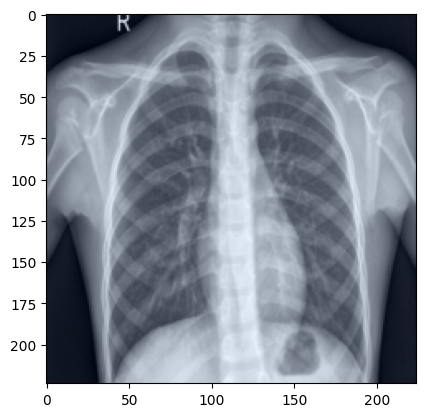

In [56]:

img = images.squeeze(0)
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img.permute(1, 2, 0))


In [71]:
input_tensor = images  # Your image tensor

# Compute attributions
attributions = ig.attribute(input_tensor, target=0)


In [ ]:
attributions = attributions.squeeze().cpu().detach().numpy()


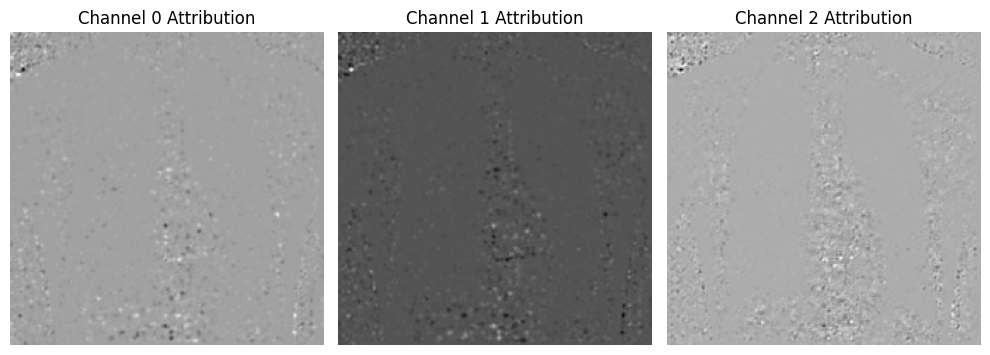

In [70]:
# Assuming you want to visualize attributions for the first image in the batch


plt.figure(figsize=(10, 5))

# Plot attributions for each channel (assuming RGB image)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(attributions[i], cmap='gray')
    plt.title(f'Channel {i} Attribution')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [73]:
input_tensor = images 

# Compute attributions for each channel separately
attributions = []
for channel in range(3):  # Iterate over RGB channels
    ig = IntegratedGradients(model)
    attr, _ = ig.attribute(input_tensor[:, channel, :, :], target=None, return_convergence_delta=False)
    attributions.append(attr)

# Stack attributions along the channel dimension
attributions = torch.stack(attributions, dim=1)  # Shape: [batch_size, 3, height, width]


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 50, 224, 224] to have 3 channels, but got 50 channels instead